# Metodologia para simulação númerica

Dada a função de benchmark com duas variavéis c $x_1$ e $x_2$ como entradas

$$
    f(x_1, x_2) = 1.3356(1.5(1-x_1))
                + e^{2x_1 - 1}sen(3\pi(x_1 - 0.6)^2)
                + e^{3(x_2 - 0.5)}sen(4\pi(x_2 - 0.9)^2)
$$

Aonde $x_1$ e $x_2$ são mutualmente independentes; $\hat{x} = [x1, x2]^T$ diz respeito a distribuição padrão e uniforme com $\hat{x} \sim U(0, 1)$

1. Selecionar conjunto de dados original com 30 pontos e computar a projeção $s$ de cada amostra ao longo de cada dimensão
2. Calcular a distância média para todos os pontos ordenados e projetados na dimensão de $x_1$ segundo a equação
$$ avgDist = \frac{1}{n-1}\sum_{i=1}^{n-1} dist(s_i^m, s_{i+1}^m) $$ 
$$ dist(s_i^m, s_{i+1}^m) = \left \| s_i^m s_{i+1}^m   \right \|^2 ; i = 1, 2, ..., n-1; m = 1, 2, ..., d $$
3. Encontrar regiões esparsas definidas por 
 $$ avgDist \leq dist_i$$
4. Gerar um novo ponto $x_i^{\sim m}$ no centro do intervalo esparso
$$x_i^{\sim m} = \frac{1}{2}(s_i^m, s_{i+1}^m)$$
5. Calcular quantis para $x_2$
6. Para cada novo ponto na dimensão $x_1$, combinar com os quantis de $x_2$ para gerar amostras virtuais multidimensionais. 


>fisherman first fixes the other directions of the fishing nets with some predetermined fibers, and then draws the fibers from the remaining single direction, thereby interweaving the fibers in different directions into mesh structures

Quantis são pontos estabelecidos em intervalos regulares a partir de uma função de distribuição acumulada de uma variável aleatória. Os quantis dividem os dados ordenados em q subconjuntos de dados de dimensão essencialmente igual.

- Primeiro quartil (Q1): 0.25 
- Segundo quartil (Q2): 0.5 é a mediana, 50% dos valores estão acima e 50% abaixo
- Terceiro quartil (Q3): 0.75
- Percentil: Dividem os dados em 100 parte iguais

São úteis para entender a distribuição dos dados e identificar *valores representativos* dentro do conjunto de dados.

Em vez de apenas adicionar novos pontos na mesma dimensão onde o intervalo esparso foi identificado, combinamos esses novos pontos com valores representativos (quantis) das outras dimensões.

Por exemplo, se identificamos um intervalo esparso na dimensão de $x_1$, geramos novos pontos no meio deste intervalo e combinamos esses pontos com quantis de $x_2$ para gerar amostras multidimensionais.

Combinando novos pontos gerados em regiões esparsas com quantis de outras dimensões, garantimos que os novos pontos adicionados são representativos e mantêm a variabilidade das amostras originais, cobrindo regiões do espaço de entrada que poderiam estar subamostradas.

Tomando $Q^m_{\alpha}$ = $\alpha$ quantil dos pontos de projeção que satisfaz $P(s^m \leq Q^m_{\alpha}) = \alpha$ têm se 
$$ x_i^{\sim q} = Q^m_{\alpha}$$ 
Para todas as dimensões exceto a m-ésima 

Combinando os novos pontos atraves de todas as dimensões, as amostras virtuais podem ser geradas no espaço da entrada como

$$ x_i^{\sim k} =\left\{\begin{matrix}
 \frac{1}{2}(s_i^m, s_{i+1}^m) ; k = m; avgDist \leq dist_i \\
 Q^m_{\alpha} ; k = q; q = \{ 1, 2, ..., d\}; q \neq m
\end{matrix}\right.
 $$

- O metódo proposto pode gerar não mais que $(n - 1)d|Q_{\alpha}|{d-1}$ amostras
- Para que as amostra virtuais cubram todo o espaço de entrada, convém escolher $\alpha$ de $[0.025, 0.25, 0.5, 0.75, 0.975]$ para que $Q_{\alpha}$ represente a distribuição subjacente dos pontos originais

> A saida das amostras virtuais $\tilde{x_i}$ geradas no espaço de entrada podem ser determinadas no espaço de saida usando o metodo Kriging pré estabilizado de aproximação de modelo baseado no conjunto de dados originais

$$ Z^{*}(\bar{x_0}) = \mu(\bar{x}) + \sum _{i=1}^{n} \lambda_i (Z(\bar{x_i} - \mu(\bar{x}))) $$

$$ A\lambda = b$$


## 1. Importando dados


In [1]:
import numpy as np
import pandas as pd
from pylab import *
import numpy as np
from pandas import DataFrame, Series
from scipy.spatial.distance import pdist, squareform

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_training = pd.read_excel("Kriging-data.xlsx", sheet_name="Training")

/tmp/ipykernel_9006/2021560843.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
  # param P: array contendo coordenadas espaciais e o valor da varíavel nesse ponto
  #     [x, y, P(x, y)]
  #  param h: Distância entre os pontos
  #  param bandWidth: Largura da banda para considerar pares de pontos.

class Semivariogram():
    def __init__(self, data, bandWidth, h_max):
      self.P = np.array(data[['x1','x2','f(x1,x2)']])
      self.bw = bandWidth
      self.hs = np.arange(0, h_max, bandWidth)

    # Calcula o variograma experimental para uma única distância h
    def SVh(self, P, h, bw):
      points_distance = squareform(pdist(P[:, :2]))  # Calcula as distâncias entre todos os pontos
      mask = (points_distance >= h - bw) & (points_distance <= h + bw) # Selecionar as distâncias que estão dentro da faixa de interesse (h - bw a h + bw).
      i, j = np.triu_indices_from(points_distance, k=1) # Obter elementos acima da diagonal principal
      valid_pairs = mask[i, j] # Selecionar os pares válidos
      Z = (P[i[valid_pairs], 2] - P[j[valid_pairs], 2]) ** 2
      return np.sum(Z) / (2.0 * len(Z))

    # Calcula o variograma experimental para um conjunto de distâncias hs
    def SV(self, P, hs, bw):
      sv = list()
      for h in hs:
          sv.append(self.SVh( P, h, bw ))
      sv = [[hs[i], sv[i]] for i in range(len( hs )) if sv[i] > 0]
      return np.array(sv).T

    # Calcula a função de covariância para uma distância h
    def Covariance(self, P, h, bw ):
        c0 = np.var(P[:,2]) # P(x, y)
        if h == 0:
            return c0
        return c0 - self.SVh( P, h, bw )

    def PlotSemivariogram(self):
      self.sv = self.SV(self.P, self.hs, self.bw)
      plot(self.sv[0], self.sv[1], '.-')
      xlabel('Lag [m]')
      ylabel('Semivariance')
      title('Sample Semivariogram')


0.47248170474412715


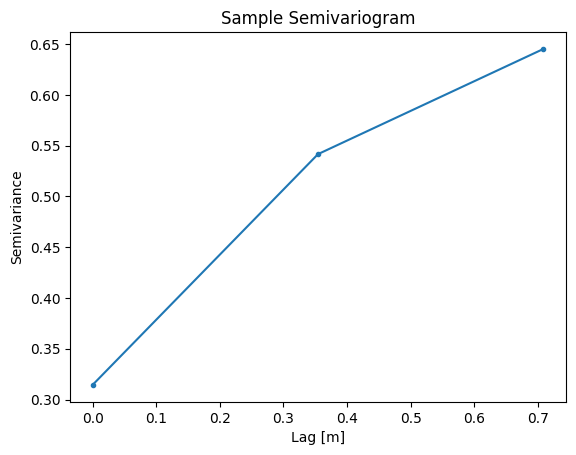

In [4]:
points = df_training[['x1', 'x2']].values
distances = pdist(points, "euclidean")
mean_distance = np.mean(distances)

print(mean_distance)
# Definir bandWidth e h_max
bandWidth = mean_distance * 0.75
h_max = np.max(distances) * 0.75

semivariogram = Semivariogram(data=df_training, bandWidth=bandWidth, h_max=h_max)
semivariogram.PlotSemivariogram()

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class Modelling:
    def __init__(self, semivariogram):
        self.sv = semivariogram.sv
        self.P = semivariogram.P
        self.bw = semivariogram.bw
        self.hs = semivariogram.hs

  # Otimiza um parâmetro de um modelo de semivariograma.
  # Computa o mse entre os valores observados e os valores preditos pelo modelo
  # Para uma serie de parametros e escolhe o que leva ao menor erro
    def opt(self, fct, x, y, sill, parameterRange, meshSize):
        prameters = np.linspace(parameterRange[0], parameterRange[1], meshSize)
        mse = np.zeros(meshSize)
        for i in range(meshSize):
            mse[i] = np.mean((y - np.array(fct(x, prameters[i], sill))) ** 2.0)
        return prameters[mse.argmin()]

    def spherical(self, h, range, sill):
        h = np.asarray(h)
        gamma = np.where(h <= range, sill * (1.5 * (h / range) - 0.5 * (h / range) ** 3), sill)
        return gamma

    def exponential(self, h, range, sill):
        h = np.asarray(h)
        gamma = sill * (1 - np.exp(-h / range))
        return gamma

    def gaussian(self, h, range, sill):
        h = np.asarray(h)
        gamma = sill * (1 - np.exp(- (h / range) ** 2))
        return gamma

    def cvmodel(self, model):
        sill = np.var(self.P[:, 2]) # Variancia dos pontos P(x, y)
        range = self.opt(model, self.sv[0], self.sv[1], sill, [self.hs[1], self.hs[-1]], 100)
        return lambda h: model(h, range, sill)

    def plotModel(self, model, model_name):
        sp = self.cvmodel(model)
        plt.plot(self.sv[0], self.sv[1], '.-', label='Empirical')
        plt.plot(self.sv[0], sp(self.sv[0]), label=f'{model_name} Model')
        plt.title(f'{model_name} Model')
        plt.ylabel('Semivariance')
        plt.xlabel('Lag [m]')
        plt.legend()
        plt.show()

    def calculate_mse(self, model):
        sp = self.cvmodel(model)
        mse = np.mean((self.sv[1] - sp(self.sv[0])) ** 2.0)
        return mse

    def FindBetter(self):
        models = {
            "Spherical": self.spherical,
            "Exponential": self.exponential,
            "Gaussian": self.gaussian
        }
        mse_values = {name: self.calculate_mse(model) for name, model in models.items()}
        best_model_name = min(mse_values, key=mse_values.get)
        print(f"Mse: {mse_values} => Melhor modelo: {best_model_name}")

In [6]:
model = Modelling(semivariogram)
model.FindBetter()

Mse: {'Spherical': 0.03923445992776126, 'Exponential': 0.06260275061931127, 'Gaussian': 0.055695386559551106} => Melhor modelo: Spherical


In [7]:
from scipy.spatial.distance import pdist, squareform

'''
  Input:
      model (function): Modeling function (spherical, exponential, gaussian)
      u     (tuple): Unsampled point (x, y)
      N     (int): Number of neighboring points to consider
  Output:
      float: Kriged estimate at point u
'''
class Kriging():
    def __init__(self, semivariogram, model):
        self.sv = semivariogram.sv
        self.P = semivariogram.P
        self.bw = semivariogram.bw
        self.hs = semivariogram.hs
        self.model = model

    def SimpleKriging(self, model, unsampled_point, N=16):
      covfct = self.model.cvmodel(model) # Covariance function
      mu = np.mean(self.P[:, 2]) # Mean of the variable P(x, y)

      # Distance between the unsampled point and each data point in P
      unsampled_distances = np.sqrt((self.P[:, 0] - unsampled_point[0]) ** 2.0 +
                                    (self.P[:, 1] - unsampled_point[1]) ** 2.0)

      P = np.vstack((self.P.T, unsampled_distances)).T  # Add these distances to P
      P = P[unsampled_distances.argsort()[:N]]  # Sort P by these distances and take the first N of them

      # Apply the covariance model to the distances
      cov_vector = np.matrix(covfct(P[:, 3])).T

      # Distance between each data point in P
      distances = pdist(P[:, :2])
      cov_matrix = np.matrix(squareform(covfct(distances))) # matrix of covariance for each distance

      # Calculate the kriging weights
      weights = np.linalg.inv(cov_matrix) * cov_vector
      weights = np.array(weights)

      # Calculate the residuals
      residuals = P[:, 2] - mu

      # Calculate the estimation
      estimation = np.dot(weights.T, residuals) + mu

      return float(estimation)


    def predictUnsampled(self, model, mesh_x=80, mesh_y=100):
        X0, X1 = self.P[:, 0].min(), self.P[:, 0].max()
        Y0, Y1 = self.P[:, 1].min(), self.P[:, 1].max()
        Z = np.zeros((mesh_x, mesh_y))
        dx, dy = (X1 - X0) / mesh_y, (Y1 - Y0) / mesh_x

        X, Y = [], []
        for i in range(mesh_x):
            print(i, end=' ')
            for j in range(mesh_y):
                Z[i, j] = self.SimpleKriging(model, (dx * j, dy * i), 16)
                X.append(dx * j)
                Y.append(dy * i)
        self.X =  np.array(X)
        self.Y =  np.array(Y)
        self.Z =  Z

    def PlotKriging(self, model, model_name, mesh_x=80, mesh_y=100):
        fig, ax = plt.subplots()

        H = np.zeros_like(self.Z)
        for i in range(self.Z.shape[0]):
            for j in range(self.Z.shape[1]):
                H[i, j] = np.round(self.Z[i, j] * 3)

        im = ax.matshow(H, cmap='viridis', interpolation='nearest')
        ax.scatter(self.P[:, 0] / 200.0, self.P[:, 1] / 200.0, facecolor='none', linewidths=0.75, s=50)
        ax.set_xlim(0, 99)
        ax.set_ylim(0, 80)
        ax.set_xticks([25, 50, 75])
        ax.set_xticklabels([5000, 10000, 15000])
        ax.set_yticks([25, 50, 75])
        ax.set_yticklabels([5000, 10000, 15000])
        plt.xlabel('Lag [m]')
        plt.ylabel('Semivariance')
        plt.title(f'Kriging Map ({model_name})')
        plt.colorbar(im)
        plt.show()


In [10]:
import numpy as np

class KrigingVSG:
    def __init__(self, actual_samples_x, actual_samples_y):
        self.original_samples_x = np.array(actual_samples_x)
        self.original_samples_y = np.array(actual_samples_y)
        self.d = self.original_samples_x.shape[1]
        self.kriging_model = None
        self.virtual_samples_x = []
        self.virtual_samples_y = []

    def ComputeProjection(self):
        projections = []

        for m in range(self.d):
            x = self.original_samples_x[:, m]
            v = self.original_samples_x[:, m]
            xm_proj = (np.dot(x, v) / np.linalg.norm(v) ** 2) * v
            projections.append(np.array(np.sort(xm_proj)))
        
        return projections
           
    def SetInputSpace(self):
        projections = self.ComputeProjection()
        avg_dists = [np.mean(np.diff(proj)) for proj in projections]

        for m in range(self.d):
            Q_alpha = np.quantile(projections[m], [0.025, 0.25, 0.5, 0.75, 0.975])

            for i in range(len(projections[m]) - 1):
                dist = projections[m][i + 1] - projections[m][i]
                if dist > avg_dists[m]:
                    tilde_x = np.zeros(self.d)
                    G = (projections[m][i] + projections[m][i + 1]) / 2
                    tilde_x[m] = G
                    self.virtual_samples_x.append(tilde_x)

                    for q in range(self.d): # expande amostra gerada para a dimensão dos quantis (G, Q_0.025)...
                        if q != m:
                            tilde_q = np.zeros(self.d)
                            for quantile in Q_alpha:
                                tilde_q[m] =  G
                                tilde_q[q] = quantile
                                self.virtual_samples_x.append(np.array(tilde_q)) 
        self.virtual_samples_x = np.array(self.virtual_samples_x)

    def PrintInputSpace(self, virtual_samples_x):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.original_samples_x[:, 0], self.original_samples_x[:, 1], c='blue', label='Amostras Originais', alpha=0.6)
        plt.scatter(virtual_samples_x[:, 0], virtual_samples_x[:, 1], c='red', label='Amostras Virtuais', alpha=0.6)

        plt.xticks(np.arange(0, 1.1, 0.1))  
        plt.yticks(np.arange(0, 1.1, 0.1))  
        plt.grid(which='both', linestyle='--', linewidth=0.5)

        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title('Distribuição e Diferenciação das Amostras Originais e Geradas')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def RemoveRedundance(self, frac=0.2):
        to_remove = int(len(self.virtual_samples_x) * frac)
        df = pd.DataFrame({"x1": self.virtual_samples_x[:, 0],
                           "x2": self.virtual_samples_x[:, 1]})

        df_remove = df.sample(n=to_remove, random_state=42)
        df_result = df.drop(df_remove.index) 
        return(df_result["x1"], df_result["x2"])


    def ComputeY(self, KrigingModel, SemivariogramModel):
        X1, X2 = self.RemoveRedundance()

        y = []
        for  x1, x2 in zip(X1, X2):
            unsampledPoint = (x1, x2)
            unsampledY = KrigingModel.SimpleKriging(SemivariogramModel, unsampledPoint)
            y.append(unsampledY)
        df = pd.DataFrame({"x1": X1,
                           "x2": X2,
                           "f(x1,x2)": y})
        return df


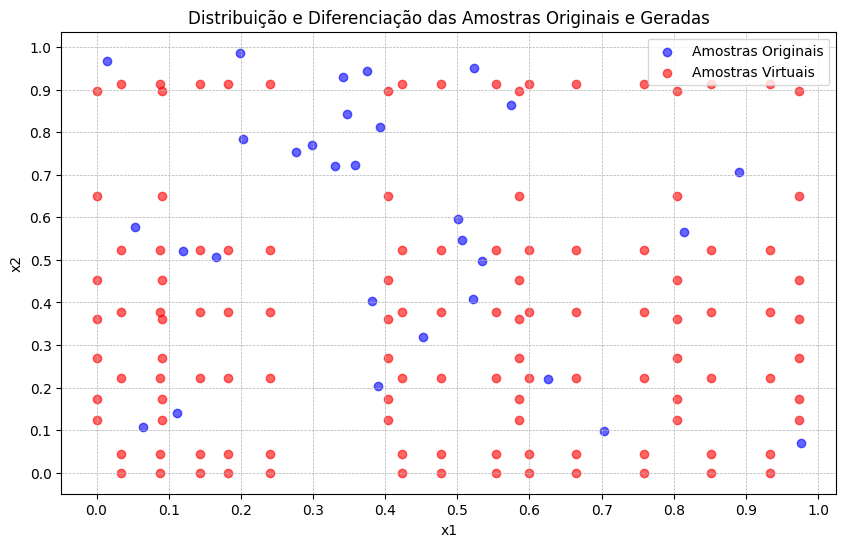

In [11]:
kriging = Kriging(semivariogram, model)
generator = KrigingVSG(df_training[['x1', 'x2']].values, df_training['f(x1,x2)'].values)
generator.SetInputSpace()
generator.PrintInputSpace(generator.virtual_samples_x)

/tmp/ipykernel_9006/2260366491.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(estimation)


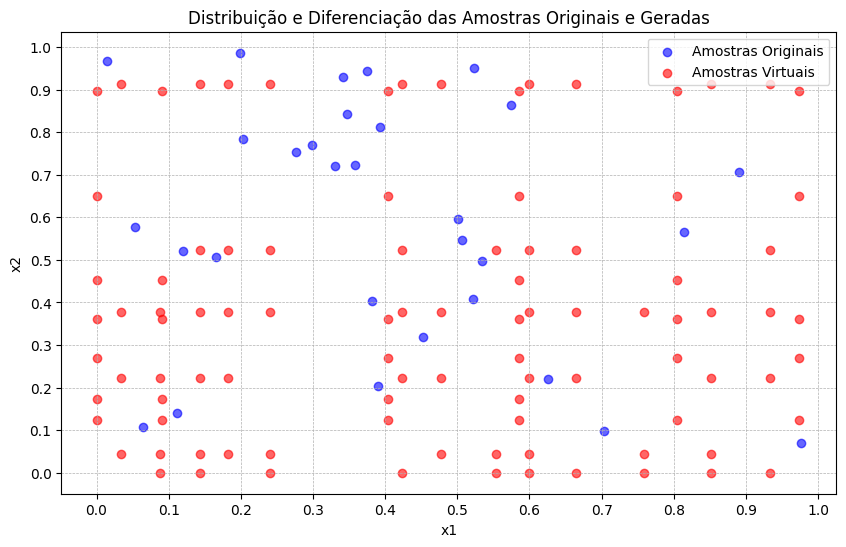

/tmp/ipykernel_9006/2260366491.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(estimation)


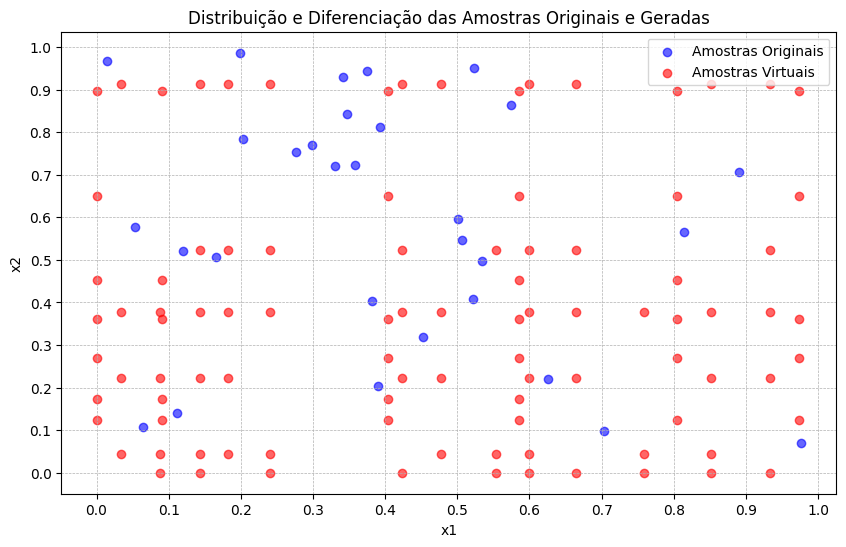

/tmp/ipykernel_9006/2260366491.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(estimation)


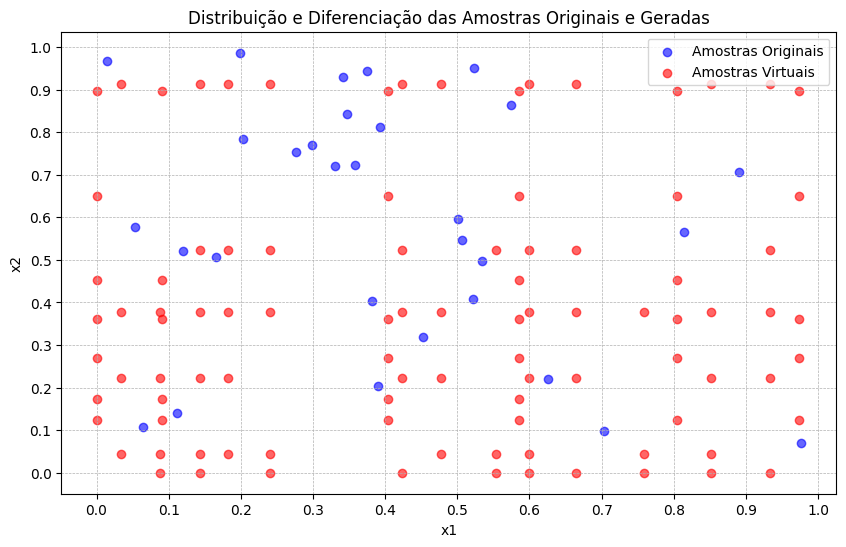

In [12]:
df_spherical = generator.ComputeY(kriging, model.spherical)
generator.PrintInputSpace(df_spherical[['x1', 'x2']].values)


df_exponential = generator.ComputeY(kriging, model.exponential)
generator.PrintInputSpace(df_exponential[['x1', 'x2']].values)


df_gaussian = generator.ComputeY(kriging, model.gaussian)
generator.PrintInputSpace(df_gaussian[['x1', 'x2']].values)


with pd.ExcelWriter("VirtualSamples.xlsx") as writer:
    df_spherical.to_excel(writer, sheet_name="Spherical", index=False)
    df_exponential.to_excel(writer, sheet_name="Exponential", index=False)  
    df_gaussian.to_excel(writer, sheet_name="Gaussian", index=False)  

# Referência bibliográfica


[1] [KRIGAGEM SIMPLES EM PYTHON]( https://connor-johnson.com/2014/03/20/simple-kriging-in-python/)

[2] [Como funciona Krigagem](https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/how-kriging-works.htm)